In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
#from util import init_weight, get_ptb_data, display_tree

%matplotlib inline

/home/skcc/apps/anaconda3/envs/tf-py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)


def find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.iteritems():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print("closest match by", name, "distance:", best_word)
        print(w1, "-", w2, "=", best_word, "-", w3)


class Tree:
    def __init__(self, word, label):
        self.left = None
        self.right = None
        self.word = word
        self.label = label


def display_tree(t, lvl=0):
    prefix = ''.join(['>']*lvl)
    if t.word is not None:
        print("%s%s %s" % (prefix, t.label, t.word))
    else:
        print("%s%s -" % (prefix, t.label))
        # if t.left is None or t.right is None:
        #     raise Exception("Tree node has no word but left and right child are None")
    if t.left:
        display_tree(t.left, lvl + 1)
    if t.right:
        display_tree(t.right, lvl + 1)


current_idx = 0
def str2tree(s, word2idx):
    # take a string that starts with ( and MAYBE ends with )
    # return the tree that it represents
    # EXAMPLE: "(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))"
    # NOTE: not every node has 2 children (possibly not correct ??)
    # NOTE: not every node has a word
    # NOTE: every node has a label
    # NOTE: labels are 0,1,2,3,4
    # NOTE: only leaf nodes have words
    # s[0] = (, s[1] = label, s[2] = space, s[3] = character or (

    # print "Input string:", s, "len:", len(s)

    global current_idx

    label = int(s[1])
    if s[3] == '(':
        t = Tree(None, label)
        # try:

        # find the string that represents left child
        # it can include trailing characters we don't need, because we'll only look up to )
        child_s = s[3:]
        t.left = str2tree(child_s, word2idx)

        # find the string that represents right child
        # can contain multiple ((( )))
        # left child is completely represented when we've closed as many as we've opened
        # we stop at 1 because the first opening paren represents the current node, not children nodes
        i = 0
        depth = 0
        for c in s:
            i += 1
            if c == '(':
                depth += 1
            elif c == ')':
                depth -= 1
                if depth == 1:
                    break
        # print "index of right child", i

        t.right = str2tree(s[i+1:], word2idx)

        # except Exception as e:
        #     print "Exception:", e
        #     print "Input string:", s
        #     raise e

        # if t.left is None or t.right is None:
        #     raise Exception("Tree node has no word but left and right child are None")
        return t
    else:
        # this has a word, so it's a leaf
        r = s.split(')', 1)[0]
        word = r[3:].lower()
        # print "word found:", word

        if word not in word2idx:
            word2idx[word] = current_idx
            current_idx += 1

        t = Tree(word2idx[word], label)
        return t


def get_ptb_data():
    # like the wikipedia dataset, I want to return 2 things:
    # word2idx mapping, sentences
    # here the sentences should be Tree objects

    word2idx = {}
    train = []
    test = []

    # train set first
    for line in open('./train.txt'):
        line = line.rstrip()
        if line:
            t = str2tree(line, word2idx)
            # if t.word is None and t.left is None and t.right is None:
            #     print "sentence:", line
            # display_tree(t)
            # print ""
            train.append(t)
            # break

    # test set
    for line in open('./test.txt'):
        line = line.rstrip()
        if line:
            t = str2tree(line, word2idx)
            test.append(t)
    return train, test, word2idx

# get_ptb_data()

In [3]:
def tensor_mul(d, x1, A, x2):
    A = tf.reshape(A, [d, d*d])
    # (1 x d) x (d x dd)
    tmp = tf.matmul(x1, A)
    # (1 x dd)
    tmp = tf.reshape(tmp, [d, d])
    # (d x d)
    tmp = tf.matmul(tmp, tf.transpose(x2))
    # (d x 1)
    return tf.reshape(tmp, [1, d])

In [4]:
def get_labels(tree):
    # must be returned in the same order as tree logits are returned
    # post-order traversal
    if tree is None:
        return []
    return get_labels(tree.left) + get_labels(tree.right) + [tree.label]

In [5]:
class RNTN:
    def __init__(self, V, D, K, activation):
        self.D = D
        self.f = activation

        # word embedding
        We = init_weight(V, D)

        # quadratic terms
        W11 = np.random.randn(D, D, D) / np.sqrt(3*D)
        W22 = np.random.randn(D, D, D) / np.sqrt(3*D)
        W12 = np.random.randn(D, D, D) / np.sqrt(3*D)

        # linear terms
        W1 = init_weight(D, D)
        W2 = init_weight(D, D)

        # bias
        bh = np.zeros(D)

        # output layer
        Wo = init_weight(D, K)
        bo = np.zeros(K)

        # make them tensorflow variables
        self.We = tf.Variable(We.astype(np.float32))
        self.W11 = tf.Variable(W11.astype(np.float32))
        self.W22 = tf.Variable(W22.astype(np.float32))
        self.W12 = tf.Variable(W12.astype(np.float32))
        self.W1 = tf.Variable(W1.astype(np.float32))
        self.W2 = tf.Variable(W2.astype(np.float32))
        self.bh = tf.Variable(bh.astype(np.float32))
        self.Wo = tf.Variable(Wo.astype(np.float32))
        self.bo = tf.Variable(bo.astype(np.float32))
        self.params = [self.We, self.W11, self.W22, self.W12, self.W1, self.W2, self.Wo]

    def fit(self, trees, lr=10e-3, mu=0.9, reg=10e-2, epochs=5):
        train_ops = []
        costs = []
        predictions = []
        all_labels = []
        i = 0
        N = len(trees)
        print("Fitting : Compiling ops")
        for t in trees:
            i += 1
            sys.stdout.write("%d/%d\r" % (i, N))
            sys.stdout.flush()
            logits = self.get_output(t)
            labels = get_labels(t)
            all_labels.append(labels)

            cost = self.get_cost(logits, labels, reg)
            costs.append(cost)

            prediction = tf.argmax(logits, 1)
            predictions.append(prediction)

            train_op = tf.train.MomentumOptimizer(lr, mu).minimize(cost)
            train_ops.append(train_op)

        # save for later so we don't have to recompile if we call score
        self.predictions = predictions
        self.all_labels = all_labels

        self.saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        actual_costs = []
        per_epoch_costs = []
        correct_rates = []
        with tf.Session() as session:
            session.run(init)

            for i in range(epochs):
                train_ops, costs, predictions, all_labels = shuffle(train_ops, costs, predictions, all_labels)
                epoch_cost = 0
                n_correct = 0
                n_total = 0
                j = 0
                N = len(train_ops)
                for train_op, cost, prediction, labels in zip(train_ops, costs, predictions, all_labels):
                    _, c, p = session.run([train_op, cost, prediction])
                    epoch_cost += c
                    actual_costs.append(c)
                    n_correct += np.sum(p == labels)
                    n_total += len(labels)

                    j += 1
                    if j % 10 == 0:
                        #sys.stdout.write("j: %d, N: %d, c: %f\r" % (j, N, c))
                        print("\nEpoch: %d, Step: %d, Length_train_op: %d, Cost: %f\r" % (i, j, N, c))
                        #sys.stdout.flush()

                    if np.isnan(c):
                        exit()

                per_epoch_costs.append(epoch_cost)
                correct_rates.append(n_correct / float(n_total))

            self.save_path = self.saver.save(session, "./tf_model.ckpt")

        plt.plot(actual_costs)
        plt.title("cost per train_op call")
        plt.show()

        plt.plot(per_epoch_costs)
        plt.title("per epoch costs")
        plt.show()

        plt.plot(correct_rates)
        plt.title("correct rates")
        plt.show()

    def get_cost(self, logits, labels, reg):
        #cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
        ################################
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        rcost = sum(tf.nn.l2_loss(p) for p in self.params)
        cost += reg*rcost
        return cost

    # list_of_logits is an output!
    # it is added to using post-order traversal
    def get_output_recursive(self, tree, list_of_logits, is_root=True):
        if tree.word is not None:
            # this is a leaf node
            x = tf.nn.embedding_lookup(self.We, [tree.word])
        else:
            # if tree.left is None or tree.right is None:
            #     print "This tree node has no word but also has no children:"
            #     display_tree(tree)
            #     print ""
            # this node has children
            x1 = self.get_output_recursive(tree.left, list_of_logits, is_root=False)
            x2 = self.get_output_recursive(tree.right, list_of_logits, is_root=False)
            x = self.f(
                tensor_mul(self.D, x1, self.W11, x1) +
                tensor_mul(self.D, x2, self.W22, x2) +
                tensor_mul(self.D, x1, self.W12, x2) +
                tf.matmul(x1, self.W1) +
                tf.matmul(x2, self.W2) +
                self.bh)

        logits = tf.matmul(x, self.Wo) + self.bo
        list_of_logits.append(logits)

        return x

    def get_output(self, tree):
        logits = []
        try:
            self.get_output_recursive(tree, logits)
        except Exception as e:
            display_tree(tree)
            raise e
        return tf.concat(logits, 0)  ##################################### tf.concat(0, logits)

    def score(self, trees):
        if trees is None:
            predictions = self.predictions
            all_labels = self.all_labels
        else:
            # just build and run the predict_op for each tree
            # and accumulate the total
            predictions = []
            all_labels = []

            i = 0
            N = len(trees)
            print("Scoring : Compiling ops")
            for t in trees:

                i += 1
                sys.stdout.write("%d/%d\r" % (i, N))
                sys.stdout.flush()

                logits = self.get_output(t)
                labels = get_labels(t)
                all_labels.append(labels)

                prediction = tf.argmax(logits, 1)
                predictions.append(prediction)

        n_correct = 0
        n_total = 0
        with tf.Session() as session:
            self.saver.restore(session, "./tf_model.ckpt")

            for prediction, y in zip(predictions, all_labels):
                p = session.run(prediction)
                # print "pred:", p
                # print "label:", y
                # n_correct += np.sum(p == y)
                n_correct += (p[-1] == y[-1]) # we only care about the root
                n_total += len(y)

        return float(n_correct) / n_total

In [ ]:
def main():
    train, test, word2idx = get_ptb_data()

    train = train[:100]
    test = test[:100]

    V = len(word2idx)
    D = 80
    K = 5

    model = RNTN(V, D, K, tf.nn.relu)
    model.fit(train)
    print("train accuracy:", model.score(None))
    print("test accuracy:", model.score(test))

Fitting : Compiling ops
Step: 10, Length_train_op: 100, Cost: 324.028015
Step: 20, Length_train_op: 100, Cost: 317.619171
Step: 30, Length_train_op: 100, Cost: 311.362701
Step: 40, Length_train_op: 100, Cost: 305.117645
Step: 50, Length_train_op: 100, Cost: 299.097260
Step: 60, Length_train_op: 100, Cost: 293.252380
Step: 70, Length_train_op: 100, Cost: 287.390930
Step: 80, Length_train_op: 100, Cost: 281.810211
Step: 90, Length_train_op: 100, Cost: 276.122437
Step: 100, Length_train_op: 100, Cost: 270.554260
Step: 10, Length_train_op: 100, Cost: 260.864105
Step: 20, Length_train_op: 100, Cost: 250.600616
Step: 30, Length_train_op: 100, Cost: 240.858719
Step: 40, Length_train_op: 100, Cost: 231.236328
Step: 50, Length_train_op: 100, Cost: 222.211411
Step: 60, Length_train_op: 100, Cost: 213.167114
Step: 70, Length_train_op: 100, Cost: 204.766876
Step: 80, Length_train_op: 100, Cost: 196.151367
Step: 90, Length_train_op: 100, Cost: 188.007629
Step: 100, Length_train_op: 100, Cost: 180.2

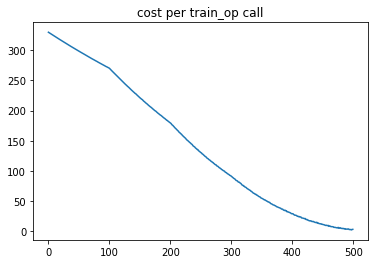

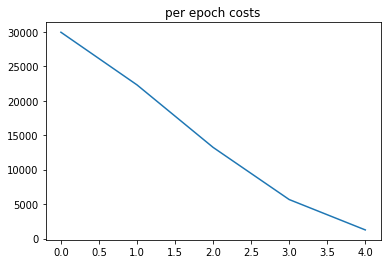

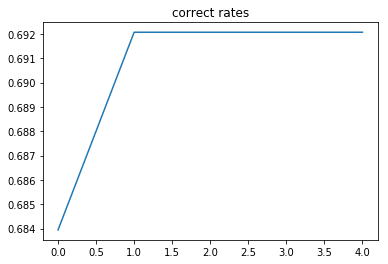

INFO:tensorflow:Restoring parameters from ./tf_model.ckpt


In [ ]:
if __name__ == '__main__':
    main()

Done.